In [ ]:
!pip install tensorboardX

from tensorboardX import SummaryWriter
from datetime import datetime
from torchvision import datasets
from collections import defaultdict, deque
import torchvision.transforms.functional as TF
import torchvision.transforms as TT
import itertools
import torchvision.models as models
import torch, os, random, zipfile, re, pickle, logging
from copy import deepcopy
from collections import OrderedDict
import numpy as np, torch.nn as nn, pandas as pd,\
torch.nn.functional as F, matplotlib.pyplot as plt,\
seaborn as sn
from time import time, sleep
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, LambdaLR
from string import punctuation
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    Subset, 
    RandomSampler, 
    SequentialSampler, 
    Dataset
)
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, 
    roc_auc_score, 
    precision_recall_fscore_support
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def download_dirs(dirlist):
    from google.colab import files
    for dirname in dirlist:
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)
            files.download(filename)

def get_dataLoader(dataset, valid_portion, batch_sizes, shuffle_indices, pretrain=False, pre_seed=None, **kwargs):
    n_samples = len(dataset)
    valid_size = int(len(dataset)*valid_portion)
    train_size = len(dataset)-valid_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    if pretrain and pre_seed:
        new_seed = np.random.randint(pre_seed+100, 2*pre_seed+101)
        fix_seed(new_seed, random_lib=True, numpy_lib=True, torch_lib=True)
    train_loader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_sizes[0], **kwargs
    )
    valid_loader = DataLoader(
        valid_dataset, shuffle=False, batch_size=batch_sizes[1], **kwargs
    )
    return train_loader, valid_loader

def fix_seed(seed_value, random_lib=False, numpy_lib=False, torch_lib=False):
    if random_lib:
        random.seed(seed_value)
    if numpy_lib:
        np.random.seed(seed_value)
    if torch_lib:
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

def setup_logger(name, format=None, level=logging.DEBUG, handlers=None, log_file='default.log'):
    logging.basicConfig(
        level=level, 
        format=format if format else '%(asctime)s [%(levelname)s] %(message)s',
        handlers=handlers if handlers else [
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(name)
    logger.setLevel(level)

def make_configure():
    import argparse
    parser = argparse.ArgumentParser(description='Model Configuration')
    parser.add_argument('--lr', type=float, default=.001, help='learning rate')
    parser.add_argument('--n_epochs', type=int, help='number of epochs')
    args = parser.parse_args()
    return args

In [ ]:
from torch.optim.optimizer import Optimizer, required
from typing import List
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.ge(0),
                        torch.where(
                            g_norm.ge(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True


class SimCLRModel(nn.Module):
    def __init__(self, n_out_classes, fc_hidden_size, pretrained):
        super(SimCLRModel, self).__init__()
        self.resnet = models.resnet50(pretrained = pretrained, progress = True)
        # conv1_state_dict = self.resnet.conv1.state_dict()
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        # self.resnet.conv1.load_state_dict(conv1_state_dict)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.projection = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(in_features=2048, out_features=fc_hidden_size, bias=True)),
            ('bn', nn.BatchNorm1d(fc_hidden_size)),
            ('relu', nn.ReLU()),
            ('linear2', nn.Linear(in_features=fc_hidden_size, out_features=n_out_classes, bias=True))
        ]))
        def init_weights(m):
          # if type(m) == nn.Linear:
              # nn.init.xavier_uniform(m.weight)
              # m.bias.data.fill_(0.01)
          if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        self.projection.apply(init_weights)
      
    def forward(self, x_i, x_j):
        # log_logits = F.log_softmax(self.resnet(x))
        emb_i, emb_j = self.resnet(x_i), self.resnet(x_j)
        z_i, z_j = self.projection(emb_i), self.projection(emb_j)
        return z_i, z_j


class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5, exclude_closest=False):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.exclude_closest = exclude_closest
            
    def forward(self, z_i, z_j, normalize=True):
        if normalize:
            z_i = F.normalize(z_i, dim=1)
            z_j = F.normalize(z_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)

        if self.exclude_closest:
            ones_vect = torch.ones(self.batch_size, dtype=torch.int8)
            mask = ~((torch.eye(2*self.batch_size, dtype=torch.int8)+\
                      torch.diag(ones_vect, diagonal=self.batch_size)+\
                      torch.diag(ones_vect, diagonal=-self.batch_size)).bool()).to('cuda')
            closest_idx = (similarity_matrix*mask).argmax(dim=1)
            stacked_closest_idx = torch.column_stack(
                (closest_idx[:(2*self.batch_size)//2], closest_idx[(2*self.batch_size)//2:])
            )
            stacked_closest_idx = torch.cat([stacked_closest_idx, stacked_closest_idx])
            denominator[torch.arange(2*self.batch_size).unsqueeze(1), stacked_closest_idx] = .0
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss


class CifarOrginalSimCLR(datasets.CIFAR10):
    def __init__(self, path, target_size=None, preprocess=[], augmentations=[], train=True):
        super().__init__(path, train, download=True)
        if target_size is None:
            img, _ = super().__getitem__(0)
            self.target_size = TT.ToTensor()(img).size()[1:]
        else:
            self.target_size = taget_size
        self.set_transforms(preprocess, augmentations)

    def set_transforms(self, preprocess: list=[], augmentations: list=[]):
        if not preprocess:
            self.preprocess = self.default_preprocess()
        else:
            self.preprocess = preprocess
        if not augmentations:
            self.augmentations = self.default_augmentations()
        else:
            self.augmentations = augmentations
        self.custom_transforms = TT.Compose([
            *self.augmentations,
            *self.preprocess
        ])
    
    def default_augmentations(self):
        augmentations = [
            TT.RandomResizedCrop(
                self.target_size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)
            ),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomApply([
                TT.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)
            ], p=0.8),
        ]
        return augmentations

    def default_preprocess(self):
        preprocess = [
            TT.ToTensor(),
            TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
        return preprocess

    def __len__(self):
        return super().__len__()

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        return self.custom_transforms(img), self.custom_transforms(img)


class TrainTest():
    def __init__(self, model, criterion, logger=None, writer=None):
        self.model = model
        self.criterion = criterion
        self.logger = logger
        self.writer = writer
        self.tr_metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'valid_loss': [],
            'valid_accuracy': [],
        }

    def train(
            self, train_loader, valid_loader,
            num_epochs, device, eval_interval,
            clip=None, model_path=None,
            save_per_epoch=None, results_path=None,
            model_name=''
    ):
        total_itrs = num_epochs * len(train_loader)
        num_tr, total_tr_loss, itr, step = 0, 0, 0, 0
        self.model.train()
        for epoch in range(num_epochs):
            for i, tr_inputs in enumerate(train_loader):
                self.optimizer.zero_grad()
                tr_output, tr_labels = self.feed_forward(tr_inputs, device)
                tr_loss = self.compute_loss(tr_output, tr_labels)
                # nn.utils.clip_grad_norm_(model.parameters(), clip)
                if self.logger:
                    self.logger.info(f'Training: {itr}/{total_itrs} -- loss: {tr_loss.item()}')
                tr_loss.backward()
                self.optimizer.step()
                num_tr += 1
                total_tr_loss += tr_loss
                if itr % eval_interval == 0 or itr + 1 == total_itrs:
                    self.tr_metrics['train_loss'].append(total_tr_loss.cpu().item() / num_tr)
                    tr_accuracy = self.cal_accuracy(tr_output, tr_labels)
                    self.tr_metrics['train_accuracy'].append(tr_accuracy)
                    num_tr, total_tr_loss = 0, 0
                    val_loss = 0
                    self.model.eval()
                    val_accuracy = []
                    with torch.no_grad():
                        for i, val_inputs in enumerate(valid_loader):
                            self.optimizer.zero_grad()
                            val_output, val_labels = self.feed_forward(val_inputs, device)
                            val_loss += self.compute_loss(val_output, val_labels)
                            val_accuracy.append(self.cal_accuracy(val_output, val_labels))
                    self.tr_metrics['valid_accuracy'].append(np.mean(val_accuracy))
                    self.tr_metrics['valid_loss'].append(val_loss.cpu().item() / len(valid_loader))
                    self.model.train()
                    if self.logger:
                        self.logger.info(f'Training: iteration: {itr}/{total_itrs} -- epoch: {epoch} -- '
                                         f' train_loss: {self.tr_metrics["train_loss"][-1]:.3f} -- train_accuracy: {self.tr_metrics["train_accuracy"][-1]:.2f}'
                                         f' valid_loss: {self.tr_metrics["valid_loss"][-1]:.3f} -- valid_accuracy: {self.tr_metrics["valid_accuracy"][-1]:.2f}')
                        self.writer.add_scalar('train-loss', self.tr_metrics["train_loss"][-1], global_step=step)
                        self.writer.add_scalar('valid-loss', self.tr_metrics["valid_loss"][-1], global_step=step)
                        self.writer.add_scalar('train-accuracy', self.tr_metrics["train_accuracy"][-1], global_step=step)
                        self.writer.add_scalar('valid-accuracy', self.tr_metrics["valid_accuracy"][-1], global_step=step)
                    step += 1
                itr += 1
            self.scheduler.step()
            if model_path and results_path and ((epoch + 1) % save_per_epoch == 0) and epoch != 0:
                self.save_model(epoch + 1, model_path, f'{model_name}_{epoch + 1}_epochs_train')
                self.save_results(results_path, f'{model_name}_{epoch + 1}_epochs_train', self.tr_metrics)
        if model_path and results_path:
            self.save_model(epoch + 1, model_path, f'{model_name}_{epoch + 1}_epochs_last_train')
            self.save_results(results_path, f'{model_name}_{epoch + 1}_epochs_last_train', self.tr_metrics)
    
    def load_trained_model(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        return checkpoint['epoch']

    def load_training_results(self, path):
        with open(path, 'rb') as results_file:
            training_results = pickle.load(results_file)
        self.tr_metrics = training_results

    def continue_train(
            self, train_loader, valid_loader,
            model_path, results_path,
            num_epochs, device, eval_interval,
            clip=None, save_per_epoch=None, model_name=''
        ):
        last_epoch = self.load_trained_model(model_path)
        self.load_training_results(results_path)
        self.train(
            train_loader, valid_loader, num_epochs,
            device, eval_interval,
            model_path='/'.join([str(x) for x in model_path.split('/')[:-1]])+'/',
            save_per_epoch=save_per_epoch,
            results_path='/'.join([str(x) for x in results_path.split('/')[:-1]])+'/',
            clip=clip,
            model_name=model_name
        )
    
    def set_optimizer(self, optimizer, **kwargs):
        if optimizer == 'Adam':
            from torch.optim import Adam
            self.optimizer = Adam(self.model.parameters(), **kwargs)
        elif optimizer == 'SGD':
            from torch.optim import SGD
            self.optimizer = SGD(self.model.parameters(), **kwargs)
        else:
            self.optimizer = optimizer(self.model.parameters(), **kwargs)

    def set_scheduler(self, scheduler, **kwargs):
        if scheduler == 'LambdaLR':
            from torch.optim.lr_scheduler import LambdaLR
            self.scheduler = LambdaLR(self.optimizer, **kwargs)
        if scheduler == 'StepLR':
            from torch.optim.lr_scheduler import StepLR
            self.scheduler = StepLR(self.optimizer, **kwargs)
        else:
            self.scheduler = scheduler(self.optimizer, **kwargs)

    # this method should be inherited by the childerens
    def feed_forward(self, inputs, device):
        pass

    # this method might be inherited by the childerens
    def compute_loss(self, output, labels):
        return self.criterion(output, labels.view(-1))
    
    # this method might be inherited by the childerens
    @classmethod    
    def cal_accuracy(cls, pred_labels, true_labels):
        _, pred_labels = pred_labels.max(dim=1)
        true_labels = true_labels.view(-1)
        return torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]

    def save_model(self, epoch, model_path, name):
        model_dir = '/'.join(model_path.split('/')[:-1])
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': self.tr_metrics['valid_loss'][-1],
            }, os.path.join(model_dir, f'model_{name}.pt')
        )
        if self.logger:
            self.logger.info(f'Training: model saved to: {model_dir}/model_{name}.pt')

    def save_results(self, results_path, name, results):
        results_dir = '/'.join(results_path.split('/')[:-1])
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        with open(os.path.join(results_dir, f'results_{name}.pkl'), 'wb') as save_file:
            pickle.dump(results, save_file)
        if self.logger:
            self.logger.info(f'Training: results saved to: {results_dir}/resutls_{name}.pkl')
    
    def freeze_layers(self, freezing_param_names):
        for name, param in self.model.named_parameters():
            if name in freezing_param_names:
                param.requires_grad = False

    def test(self, ts_loader, device, model_name='', label_names=None, results_path=None):
        ts_accuracy, ts_true, ts_pred = [], [], []
        ts_loss = 0
        self.model.eval()
        with torch.no_grad():
            for i, ts_inputs in enumerate(ts_loader):
                self.optimizer.zero_grad()
                ts_output, ts_labels = self.feed_forward(ts_inputs, device)
                ts_loss += self.compute_loss(ts_output, ts_labels)
                ts_accuracy.append(self.cal_accuracy(ts_output, ts_labels))
                ts_true.append(ts_labels.cpu())
                ts_pred.append(ts_output.cpu().max(dim=1)[1])
        ts_true = torch.cat(ts_true)
        ts_pred = torch.cat(ts_pred)
        ts_loss = ts_loss.cpu().item() / len(ts_loader)
        ts_accuracy = np.mean(ts_accuracy)
        prf = precision_recall_fscore_support(
            ts_true,
            ts_pred,
            labels=label_names,
            average='weighted'
        )
        confm = confusion_matrix(ts_true, ts_pred, labels=label_names)
        self.ts_metrics = {
            'loss': ts_loss,
            'accuracy': ts_accuracy,
            'precision': prf[0],
            'recall': prf[1],
            'f1_score': prf[2],
            'confusion_matrix': confm
        }
        if self.logger:
            print(
                f'tsing: ts_loss: {ts_loss:.3f} -- ts_accurcy: {ts_accuracy:.2f}')
        if results_path:
            self.save_results(results_path, f'{model_name}_ts', self.ts_metrics)


class TrainerSimCLROriginal(TrainTest):
    def __init__(self, model, criterion, logger=None, writer=None):
        super(TrainerSimCLROriginal, self).__init__(model, criterion, logger, writer)

    def feed_forward(self, inputs, device):
        imgs_i, imgs_j = inputs[0].to(device), inputs[1].to(device)
        z_i, z_j = self.model(imgs_i, imgs_j)
        return (z_i, z_j),None

    def compute_loss(self, output, labels):
        return self.criterion(output[0], output[1])
    
    @classmethod
    def cal_accuracy(cls, pred_labels, true_labels):
        return 1.0


class CustomRandomSolarize(object):
    def __init__(self, low_threshold, high_threshold, p):
        self.p = p
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
    
    def __call__(self, img):
        t = random.choice(range(self.low_threshold, self.high_threshold))
        return TT.RandomSolarize(t, self.p)(img)


class FineTuningSimpleTrainer(TrainTest):
    def __init__(self, model, criterion, logger=None, writer=None):
        super(FineTuningSimpleTrainer, self).__init__(model, criterion, logger, writer)

    def feed_forward(self, inputs, device):
        imgs, labels = inputs[0].to(device), inputs[1].to(device)
        output = self.model(imgs)
        return output, labels

# Setting

In [ ]:
cuda_flag = True if torch.cuda.is_available() else False
eval_interval = 500
save_model = True
device = torch.device('cuda' if cuda_flag else 'cpu')
params = {'num_workers': 2, 'pin_memory': True, 'drop_last': True,} if cuda_flag else {}
valid_portion = 0.1
batch_sizes = [128, 128]
seed = 20215
fix_seed(seed, random_lib=True, numpy_lib=True, torch_lib=True)

open('metrics.log', 'w').close()
logger = setup_logger(name='track_logger', level=logging.INFO, log_file='metrics.log')
writer = SummaryWriter(f'run/{datetime.now().strftime("%b-%d-%Y-%I:%M%p")}')

# Pre-Training and Fine-Tuning

In [ ]:
def pretrain(traintest, train_dataset, num_epochs, model_name, run_from_begining=True, pretrain_model_path='', pretrain_results_path=''):
    # traintest.set_optimizer(
    #     LARS, lr=0.3*batch_sizes[0]/256,
    #     weight_decay=1.0e-6,
    #     exclude_from_weight_decay=["batch_normalization", "bias"]
    # )
    traintest.set_optimizer('Adam', lr=3e-4,)
    traintest.set_scheduler(
        torch.optim.lr_scheduler.CosineAnnealingLR,
        T_max=num_epochs, eta_min=0, last_epoch=-1
    )
    if run_from_begining:
        train_loader, valid_loader = get_dataLoader(
            train_dataset,
            valid_portion,
            batch_sizes,
            shuffle_indices=True, **params
        )

        traintest.train(
            train_loader,
            valid_loader,
            num_epochs,
            device,
            eval_interval,
            model_path='/content/drive/MyDrive/deep-models/models/',
            save_per_epoch=11,
            results_path='/content/drive/MyDrive/deep-models/results/',
            clip=5,
            model_name=model_name
        )
    else:
        train_loader, valid_loader = get_dataLoader(
            train_dataset,
            valid_portion,
            batch_sizes,
            shuffle_indices=True, pretrain=True, pre_seed=20215, **params
        )

        traintest.continue_train(
            train_loader,
            valid_loader,
            pretrain_model_path,
            pretrain_results_path,
            num_epochs,
            device,
            eval_interval,
            save_per_epoch=10,
            model_name=model_name
        )


def fine_tune(pretrained_path, num_epochs, model_name):
    n_classes = 10
    custom_transform = TT.Compose([
        TT.ToTensor(),
        TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    name = 'last_layer'
    train_dataset = datasets.CIFAR10(root='.', train=True,
                                download=True, transform=custom_transform)
    test_dataset = datasets.CIFAR10(root='.', train=False,
                            download=True, transform=custom_transform)
    train_loader, valid_loader = get_dataLoader(
        train_dataset,
        valid_portion,
        batch_sizes,
        shuffle_indices=True, **params
    )
    test_loader = DataLoader(
        test_dataset, shuffle=False, batch_size=32, **params
    )

    pretrained_model = SimCLRModel(n_out_classes=4, fc_hidden_size=128, pretrained=False).to(device)
    checkpoint = torch.load(pretrained_path)
    pretrained_model.load_state_dict(checkpoint['model_state_dict'])
    model = models.resnet50(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Identity()
    model.load_state_dict(pretrained_model.resnet.state_dict())
    model.fc = nn.Sequential(OrderedDict([
        ('flatten', nn.Flatten(start_dim=1)),
        ('linear1', nn.Linear(2048, 256)),
        ('bn', nn.BatchNorm1d(256)),
        ('relu', nn.ReLU()),
        ('linear2', nn.Linear(256, n_classes))
    ]))
    model.to(device)
    traintest = FineTuningSimpleTrainer(model, F.cross_entropy, logger, writer)
    traintest.set_optimizer('SGD', lr=0.01, momentum=0.9)
    traintest.set_scheduler('StepLR', step_size=10, gamma=0.5)
    print([name for name, _ in model.named_parameters() if not name.startswith('fc')])
    traintest.freeze_layers([name for name, _ in model.named_parameters() if not name.startswith('fc')])
    traintest.train(
        train_loader,
        valid_loader,
        num_epochs,
        device,
        eval_interval,
        model_path='/content/drive/MyDrive/deep-models/models/',
        save_per_epoch=150,
        results_path='/content/drive/MyDrive/deep-models/results/',
        clip=5,
        model_name=f'{model_name}_{name}'
    )
    traintest.test(
        test_loader,
        device,
        results_path='/content/drive/MyDrive/deep-models/results/',
        model_name=f'{model_name}_{name}'
    )
    return traintest

# Part A.Pre-Training

In [ ]:
resnet_model = SimCLRModel(n_out_classes=4, fc_hidden_size=128, pretrained=False).to(device)
traintest = TrainerSimCLROriginal(resnet_model, ContrastiveLoss(batch_size=batch_sizes[0]).to(device), logger, writer)
train_dataset = CifarOrginalSimCLR(path='.')
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q2.1_pretrained',
    run_from_begining=True 
)

# Part A.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q2.1_pretrained_100_epochs_last_train.pt',
    num_epochs=50,
    model_name='adl_pj3_q2.1'
)

# Part B.Pre-Training

In [ ]:
augmentations = [
    TT.RandomResizedCrop(
        (32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)
    ),
    CustomRandomSolarize(
        low_threshold=100, high_threshold=200, p=0.1
    )
]
resnet_model = SimCLRModel(n_out_classes=4, fc_hidden_size=128, pretrained=False).to(device)
traintest = TrainerSimCLROriginal(resnet_model, ContrastiveLoss(batch_size=batch_sizes[0]).to(device), logger, writer)
train_dataset = CifarOrginalSimCLR(path='.', augmentations=augmentations)
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q2.2_pretrained',
    run_from_begining=True 
)

# Part B.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q2.2_pretrained_100_epochs_last_train.pt',
    num_epochs=50,
    model_name='adl_pj3_q2.2'
)

# Part C.Pre-Train

In [ ]:
resnet_model = SimCLRModel(n_out_classes=4, fc_hidden_size=128, pretrained=False).to(device)
traintest = TrainerSimCLROriginal(
    resnet_model, 
    ContrastiveLoss(batch_size=batch_sizes[0], exclude_closest=True).to(device), 
    logger, writer)
train_dataset = CifarOrginalSimCLR(path='.')
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q2.3_pretrained',
    run_from_begining=True 
)

# Part C.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q2.3_pretrained_100_epochs_last_train.pt',
    num_epochs=50,
    model_name='adl_pj3_q2.3'
)

# Plotting

In [24]:
import pickle, numpy as np, matplotlib.pyplot as plt, seaborn as sn

def get_results(path):
    with open(path, 'rb') as results_file:
        return pickle.load(results_file)

def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def print_test_result(tests):
    for i, test in enumerate(tests):
        print('*'*20, f'cifar10 test results of part {i+1} ({names[i]})', '*'*20)
        print(f'loss (last stage): {test["loss"]}\naccuracy (last stage) : {test["accuracy"]}')

# Training Results

In [17]:
train_results = [get_results(f'./results/q2/results_adl_pj3_q2.{i}_pretrained_100_epochs_last_train.pkl') for i in [1, 2, 3]]
names = ['Original', '‫‪Solarization‬‬', 'Remove Nearest']
total_records = min([len(train_results[i]['train_loss']) for i in range(len(train_results))])
sn.set_theme()
figsize = (10, 8)
cols, rows = 2, 2
eval_interval = 500
iterations = [i*eval_interval for i in range(total_records)]

<ipython-input-18-1a6f9bc4fa89>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


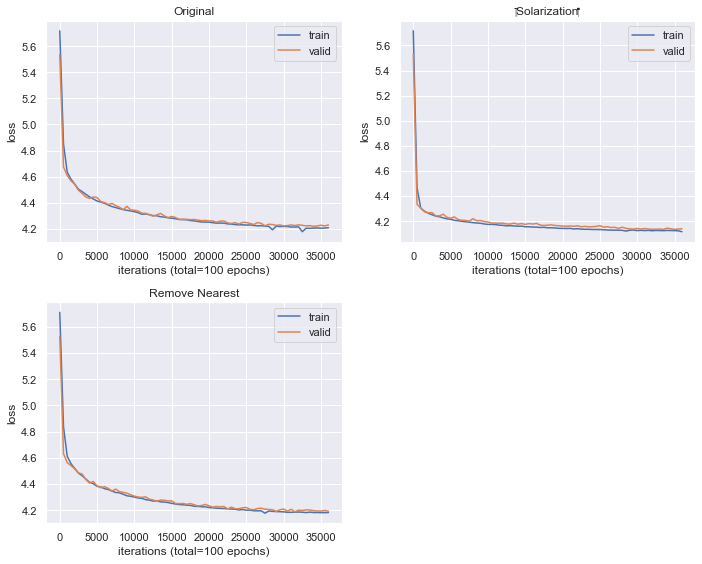

In [18]:
axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, len(train_results))
for i, (ax, train_file) in enumerate(zip(axs, train_results)):
    ax.plot(iterations, train_file['train_loss'][:total_records], label='train')
    ax.plot(iterations, train_file['valid_loss'][:total_records], label='valid')
    ax.set_ylabel('loss')
    ax.set_xlabel('iterations (total=100 epochs)')
    ax.legend(fancybox=True)
    ax.set_title(names[i])

fig = plt.gcf()
fig.tight_layout()
fig.savefig('./results/q2/loss_metrics.png', dpi=150)

# Test Results on CIFAR10

In [25]:
print_test_result(
    [get_results(f'./results/q2/results_adl_pj3_q2.{i}_last_layer_ts.pkl') for i in [1, 2, 3]]
)

******************** cifar10 test results of part 1 (Original) ********************
loss (last stage): 0.8774078564766126
accuracy (last stage) : 0.6863982371794872
******************** cifar10 test results of part 2 (‫‪Solarization‬‬) ********************
loss (last stage): 1.2758900569035456
accuracy (last stage) : 0.5302483974358975
******************** cifar10 test results of part 3 (Remove Nearest) ********************
loss (last stage): 0.8609658265725161
accuracy (last stage) : 0.6946113782051282
